# import 

https://petamind.com/mlp-for-implicit-binary-collaborative-filtering/

In [24]:
import numpy as np
import pandas as pd
import collections
from mpl_toolkits.mplot3d import Axes3D
from IPython import display
from matplotlib import pyplot as plt
import sklearn
import sklearn.manifold
from urllib.request import urlretrieve
import zipfile
import os
from sklearn.datasets import dump_svmlight_file
import numpy as np
import pandas as pd
import os
import urllib
import zipfile
from sklearn.model_selection import train_test_split
import shutil
import matplotlib.pyplot as plt
import warnings
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
warnings.filterwarnings('ignore')
%matplotlib inline

In [48]:
%autosave 300
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.3f}'.format


Autosaving every 300 seconds


In [4]:
# !pip install tensorflow --upgrade --force-reinstall



In [2]:
import tensorflow as tf

In [8]:
# print("Installing Altair...")
# !pip install git+git://github.com/altair-viz/altair.git

# read data

## example 1

In [7]:
zip_ref = zipfile.ZipFile('/data/jyu29/data/recommendation_data/movielens.zip', "r")
zip_ref.extractall()
print("Done. Dataset contains:")
print(zip_ref.read('ml-100k/u.info'))


Done. Dataset contains:
b'943 users\n1682 items\n100000 ratings\n'


In [16]:
# Load each data set (users, movies, and ratings).
users_cols = ['user_id', 'age', 'sex', 'occupation', 'zip_code']
users = pd.read_csv(
    'ml-100k/u.user', sep='|', names=users_cols, encoding='latin-1')



### rating
ratings_cols = ['user_id', 'movie_id', 'rating', 'unix_timestamp']
ratings = pd.read_csv(
    'ml-100k/u.data', sep='\t', names=ratings_cols, encoding='latin-1')


## movie
genre_cols = [
    "genre_unknown", "Action", "Adventure", "Animation", "Children", "Comedy",
    "Crime", "Documentary", "Drama", "Fantasy", "Film-Noir", "Horror",
    "Musical", "Mystery", "Romance", "Sci-Fi", "Thriller", "War", "Western"
]
movies_cols = [
    'movie_id', 'title', 'release_date', "video_release_date", "imdb_url"
] + genre_cols
movies = pd.read_csv(
    'ml-100k/u.item', sep='|', names=movies_cols, encoding='latin-1')

In [19]:
users.sample(1) #943 distinct user id

,user_id,age,sex,occupation,zip_code
30,31,24,M,artist,10003


In [10]:
ratings.sample(1) #943 distinct user id

,user_id,movie_id,rating,unix_timestamp
59413,722,13,2,891281876
39494,651,306,5,880126473


In [18]:
movies.sample(1)

,movie_id,title,release_date,video_release_date,imdb_url,genre_unknown,Action,Adventure,Animation,Children,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
1399,1400,Picture Bride (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Picture%20Bri...,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


## example 2

In [53]:
def load_movielens_data(data_directory):
    ratings_df = pd.read_csv(
    os.path.join(data_directory, "ratings.dat"),
    sep="::",
    names=["UserID", "MovieID", "Rating", "Timestamp"], engine="python")
    movies_df = pd.read_csv(
      os.path.join(data_directory, "movies.dat"),
      sep="::",
      names=["MovieID", "Title", "Genres"], engine="python")

  # Create dictionaries mapping from old IDs to new (remapped) IDs for both
  # MovieID and UserID. Use the movies and users present in ratings_df to
  # determine the mapping, since movies and users without ratings are unneeded.
    movie_mapping = {
      old_movie: new_movie for new_movie, old_movie in enumerate(
          ratings_df.MovieID.astype("category").cat.categories)
  }
    user_mapping = {
      old_user: new_user for new_user, old_user in enumerate(
          ratings_df.UserID.astype("category").cat.categories)
  }

  # Map each DataFrame consistently using the now-fixed mapping.
    ratings_df.MovieID = ratings_df.MovieID.map(movie_mapping)
    ratings_df.UserID = ratings_df.UserID.map(user_mapping)
    movies_df.MovieID = movies_df.MovieID.map(movie_mapping)

  # Remove nulls resulting from some movies being in movies_df but not
  # ratings_df.
    movies_df = movies_df[pd.notnull(movies_df.MovieID)]

    return ratings_df, movies_df

In [54]:
data_directory = '/data/jyu29/data/recommendation_data'
ratings_df, movies_df = load_movielens_data(data_directory)

In [56]:
#columns={'oldName1': 'newName1', 'oldName2': 'newName2'}
dataset = ratings_df
dataset = dataset.rename(columns = {'UserID':'user_id','MovieID':'item_id',
                                    'Rating':'rating'})
dataset.sample(2)

,user_id,item_id,rating,Timestamp
783455,4679,1059,5,963707880
377367,2202,2512,3,974610016


In [72]:
len(dataset.user_id.unique())

6040

In [73]:
len(dataset.item_id.unique())

3706

In [76]:
# use 0 has watched 53 movie out of 3706
len(dataset.loc[dataset.user_id==0])

53

### Preprocessing MovieLens Data

We'll now prepare the MovieLens dataset as a list of `tf.data.Dataset`s representing each user's data for use with TFF.

We implement two functions:
* `create_tf_datasets`: takes our ratings DataFrame and produces a list of user-split `tf.data.Dataset`s.
* `split_tf_datasets`: takes a list of datasets and splits them into train/val/test by *user*, so the val/test sets contain only ratings from users **unseen** during training. Typically in standard centralized matrix factorization we actually split so that the val/test sets contain held-out ratings from **seen** users, since unseen users don't have user embeddings. In our case, we'll see later that the approach we use to enable matrix factorization in FL also enables quickly reconstructing user embeddings for unseen users.

In [63]:
dataset.user_id = dataset.user_id.astype('category').cat.codes.values
dataset.item_id = dataset.item_id.astype('category').cat.codes.values
train, test = train_test_split(dataset, test_size=0.2)
n_users, n_movies = len(dataset.user_id.unique()), len(dataset.item_id.unique())
n_latent_factors = 50

In [66]:
users_feats = tf.constant([
                [1,0.1],
                [-1,0],
                [.2,-1],
                [.1,1]],dtype=tf.float32)

# features of the movies one-hot encoded
# e.g. columns could represent ['Action', 'Sci-Fi', 'Comedy', 'Cartoon', 'Drama']
movies_feats = tf.constant([
                [.9,-1,1,1,-0.9],
                [-0.2,-0.8,-1,0.9,1],
],dtype=tf.float32)

 Matrix factorization typically gives a more compact representation than learning the full matrix. The full matrix has  entries, while the embedding matrices  have  entries, where the embedding dimension  is typically much smaller than  and . As a result, matrix factorization finds latent structure in the data, assuming that observations lie close to a low-dimensional subspace. In the preceding example, the values of n, m, and d are so low that the advantage is negligible. In real-world recommendation systems, however, matrix factorization can be significantly more compact than learning the full matrix.
 
 
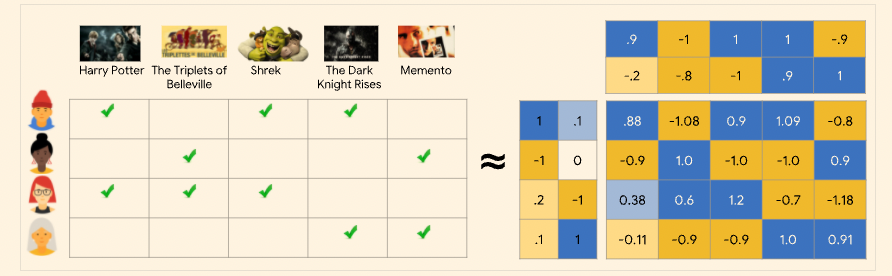


In [67]:
tf.matmul(users_feats,movies_feats)

<tf.Tensor: shape=(4, 5), dtype=float32, numpy=
array([[ 0.88      , -1.08      ,  0.9       ,  1.09      , -0.79999995],
       [-0.9       ,  1.        , -1.        , -1.        ,  0.9       ],
       [ 0.38      ,  0.6       ,  1.2       , -0.7       , -1.18      ],
       [-0.11000001, -0.90000004, -0.9       ,  1.        ,  0.91      ]],
      dtype=float32)>

Sparse Representation of the Rating Matrix

The rating matrix could be very large and, in general, most of the entries are unobserved, since a given user will only rate a small subset of movies. For effcient representation, we will use a [tf.SparseTensor](https://www.tensorflow.org/api_docs/python/tf/SparseTensor). A `SparseTensor` uses three tensors to represent the matrix: `tf.SparseTensor(indices, values, dense_shape)` represents a tensor, where a value $A_{ij} = a$ is encoded by setting `indices[k] = [i, j]` and `values[k] = a`. The last tensor `dense_shape` is used to specify the shape of the full underlying matrix.

#### Toy example
Assume we have $2$ users and $4$ movies. Our toy ratings dataframe has three ratings,

user\_id | movie\_id | rating
--:|--:|--:
0 | 0 | 5.0
0 | 1 | 3.0
1 | 3 | 1.0

The corresponding rating matrix is

$$
A =
\begin{bmatrix}
5.0 & 3.0 & 0 & 0 \\
0   &   0 & 0 & 1.0
\end{bmatrix}
$$

And the SparseTensor representation is,
```python
SparseTensor(
  indices=[[0, 0], [0, 1], [1,3]],
  values=[5.0, 3.0, 1.0],
  dense_shape=[2, 4])

In [ ]:
#@title Solution
  """
  Args:
    ratings_df: a pd.DataFrame with `user_id`, `movie_id` and `rating` columns.
  Returns:
    a tf.SparseTensor representing the ratings matrix.
  """
def build_rating_sparse_tensor(ratings_df):

    indices = ratings_df[['user_id', 'movie_id']].values
    values = ratings_df['rating'].values
    return tf.SparseTensor(indices=indices,
      values=values,
      dense_shape=[users.shape[0], movies.shape[0]])

The model approximates the ratings matrix $A$ by a low-rank product $UV^\top$. We need a way to measure the approximation error. We'll start by using the Mean Squared Error of observed entries only (we will revisit this later). It is defined as

$$
\begin{align*}
\text{MSE}(A, UV^\top)
&= \frac{1}{|\Omega|}\sum_{(i, j) \in\Omega}{( A_{ij} - (UV^\top)_{ij})^2} \\
&= \frac{1}{|\Omega|}\sum_{(i, j) \in\Omega}{( A_{ij} - \langle U_i, V_j\rangle)^2}
\end{align*}
$$
where $\Omega$ is the set of observed ratings, and $|\Omega|$ is the cardinality of $\Omega$.


# matrix factorization model

In [64]:
movie_input = keras.layers.Input(shape=[1],name='Item')
movie_embedding = keras.layers.Embedding(n_movies + 1, 
                                         n_latent_factors, 
                                         name='Movie-Embedding')(movie_input)
movie_vec = keras.layers.Flatten(name='FlattenMovies')(movie_embedding)
user_input = keras.layers.Input(shape=[1],name='User')
user_vec = keras.layers.Flatten(name='FlattenUsers')(keras.layers.Embedding(n_users + 1, n_latent_factors,name='User-Embedding')(user_input))
prod = keras.layers.dot([movie_vec, user_vec], axes=1,name='DotProduct')
model = keras.Model([user_input, movie_input], prod)
model.summary()



Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Item (InputLayer)              [(None, 1)]          0           []                               
                                                                                                  
 User (InputLayer)              [(None, 1)]          0           []                               
                                                                                                  
 Movie-Embedding (Embedding)    (None, 1, 50)        185350      ['Item[0][0]']                   
                                                                                                  
 User-Embedding (Embedding)     (None, 1, 50)        302050      ['User[0][0]']                   
                                                                                            

In [65]:
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae', 'mse'])
history = model.fit([train.user_id, train.item_id], train.rating, epochs=10)

Epoch 1/10
25006/25006 [==============================] - 55s 2ms/step - loss: 2.5670 - mae: 1.1511 - mse: 2.5670
Epoch 2/10
25006/25006 [==============================] - 54s 2ms/step - loss: 0.8466 - mae: 0.7238 - mse: 0.8466
Epoch 3/10
25006/25006 [==============================] - 54s 2ms/step - loss: 0.7587 - mae: 0.6832 - mse: 0.7587
Epoch 4/10
25006/25006 [==============================] - 55s 2ms/step - loss: 0.6789 - mae: 0.6439 - mse: 0.6789
Epoch 5/10
25006/25006 [==============================] - 55s 2ms/step - loss: 0.6087 - mae: 0.6077 - mse: 0.6087
Epoch 6/10
25006/25006 [==============================] - 55s 2ms/step - loss: 0.5540 - mae: 0.5781 - mse: 0.5540
Epoch 7/10
25006/25006 [==============================] - 54s 2ms/step - loss: 0.5156 - mae: 0.5564 - mse: 0.5156
Epoch 8/10
25006/25006 [==============================] - 55s 2ms/step - loss: 0.4877 - mae: 0.5403 - mse: 0.4877
Epoch 9/10
25006/25006 [==============================] - 55s 2ms/step - loss: 0.4674 - 

In [83]:
# embedding for users
user_embedding_learnt = model.get_layer(name='User-Embedding').get_weights()[0]

In [68]:
# embedding for movie
movie_embedding_learnt = model.get_layer(name='Movie-Embedding').get_weights()[0]
movie_embedding_learnt.shape

(3707, 50)

## visualise embedding

visualize the embedding vectors using dimensional reduction techniques such as PCA.

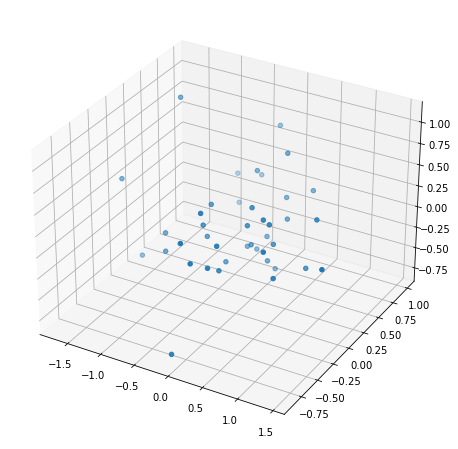

In [97]:
pca = PCA(n_components = 3)
pca.fit(user_embedding_learnt)
user_embeddings_pca = pca.transform(user_embedding_learnt)
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(111, projection = "3d")
xs, ys, zs = user_embeddings_pca[::150].T
ax.scatter(xs, ys, zs)

# recommend

To recommend top n items to a user u_i is simple now. We take the embedding vector of the user and do a *dot product* with all the embedding vectors of movies and get the top n largest values. The following code returns the top 5 most relevant movie ids.

Our goal is to factorize the ratings matrix $A$ into the product of a user embedding matrix $U$ and movie embedding matrix $V$, such that $A \approx UV^\top$ with
$U = \begin{bmatrix} u_{1} \\ \hline \vdots \\ \hline u_{N} \end{bmatrix}$ and
$V = \begin{bmatrix} v_{1} \\ \hline \vdots \\ \hline v_{M} \end{bmatrix}$.

Here
- $N$ is the number of users,
- $M$ is the number of movies,
- $A_{ij}$ is the rating of the $j$th movies by the $i$th user,
- each row $U_i$ is a $d$-dimensional vector (embedding) representing user $i$,
- each row $V_j$ is a $d$-dimensional vector (embedding) representing movie $j$,
- the prediction of the model for the $(i, j)$ pair is the dot product $\langle U_i, V_j \rangle$.


In [78]:
def recommend(user_id, number_of_movies=5):
    movies = user_embedding_learnt[user_id]@movie_embedding_learnt.T
    mids = np.argpartition(movies, -number_of_movies)[-number_of_movies:]
    return mids

In [86]:
# recommend top 5 movie for use 2
recommend(user_id=2)

array([1055, 5752, 4732, 1220,    2])

In [85]:
dataset.loc[dataset.user_id==2].item_id.unique()

array([3189, 1504,  627, 1295, 3301,  101, 2530, 1120, 1327, 3622, 1007,
       2785, 1483, 1199, 1167,  632, 1986, 1449, 3379,  253, 2651, 2898,
        982, 1169,  538,  466, 1173, 1174,  699, 1106,  576, 2162, 1107,
       1108, 1279,  579, 1280, 3318, 1212, 1178, 2277, 2952, 2415, 1781,
       3429, 1826, 2664, 1934, 1788, 1059, 1900], dtype=int16)